In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [23]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import io

In [ ]:
print(tf.__version__)

In [3]:
# Uncomment and run this if you don't have TensorFlow 2.0x [Check for latest 2.0 instructions at https://www.tensorflow.org/versions/r2.0/api_docs/python/tf]
#!pip install tensorflow==2.0.0

In [4]:
# Double check TF 2.0x is installed. If you ran the above block, there was a 
# 'reset all runtimes' button at the bottom that you needed to press
import tensorflow as tf
print(tf.__version__)

2.0.0


In [5]:
DATASET_NAME="imdb_reviews/subwords8k"

In [6]:
# Download the dataset
imdb, info = tfds.load(DATASET_NAME, with_info=True, as_supervised=True)

In [7]:
# Split the data. Reference: https://www.tensorflow.org/datasets/splits#s3_slicing_api
train_dataset, test_dataset = imdb['train'], imdb['test']

In [8]:
# Print the info from the dataset
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts

In [9]:
# Lets get the encoder. Which is a SubwordTextEncoder
# Ref: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder
tokenizer = info.features['text'].encoder

In [10]:
print ('Vocabulary size: {}'.format(tokenizer.vocab_size))

Vocabulary size: 8185


In [11]:
# Print the subwords
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [12]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [13]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [14]:
# Let's define some parameters for the network and training 
embedding_dim = 64
num_epochs = 10

In [15]:
# Let's build the model using Embeddings and passing the vocab_size already set in the tokenizer
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [16]:
# Print the summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Prepare the data for training. 
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

In [18]:
# Configure the model 
loss_fx = tf.keras.losses.BinaryCrossentropy()

In [19]:
# Configure the model 
model.compile(loss=loss_fx,
              optimizer='adam',
              metrics=['acc'])

In [20]:
# Training step 
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 14s 36ms/step - loss: 0.6844 - acc: 0.5701 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 13s 33ms/step - loss: 0.6139 - acc: 0.7436 - val_loss: 0.5563 - val_acc: 0.8158
Epoch 3/10
391/391 [==============================] - 13s 32ms/step - loss: 0.4841 - acc: 0.8443 - val_loss: 0.4493 - val_acc: 0.8420
Epoch 4/10
391/391 [==============================] - 13s 32ms/step - loss: 0.3884 - acc: 0.8856 - val_loss: 0.3951 - val_acc: 0.8522
Epoch 5/10
391/391 [==============================] - 13s 32ms/step - loss: 0.3292 - acc: 0.9022 - val_loss: 0.3527 - val_acc: 0.8774
Epoch 6/10
391/391 [==============================] - 13s 32ms/step - loss: 0.2875 - acc: 0.9144 - val_loss: 0.3552 - val_acc: 0.8589
Epoch 7/10
391/391 [==============================] - 13s 33ms/step - loss: 0.2576 - acc: 0.9206 - val_loss: 0.3225 - val_acc: 0.8810
Epoch 8/10
391/391 [==============================] - 

In [24]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

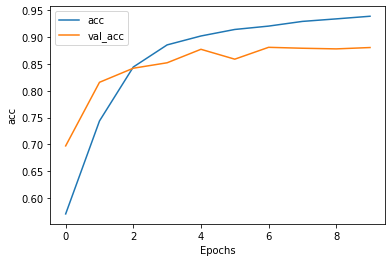

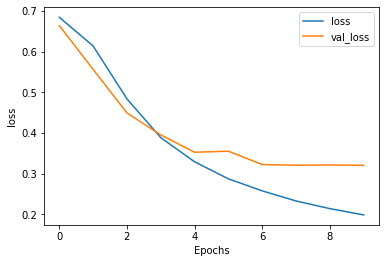

In [25]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [26]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 64)


In [27]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')